In [1]:
import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
def change_dtype_ser(ser):
    
    if ser.dtype == int:
        return ser.astype(np.int32)
    
    if ser.dtype == float:
        return ser.astype(np.float32)
    
    return ser
    

def change_dtype_df(df):
    """
    change types of columns to reduce memory size
    :param df: dataframe
    :return df: dataframe
    """
    memory = df.memory_usage().sum() / 10**6
    print("Memory usage before changing types %0.2f MB" % memory)

    for col in df.columns:
        df[col] = change_dtype_ser(df[col])

    memory = df.memory_usage().sum() / 10 ** 6
    print("Memory usage after changing types %0.2f MB" % memory)
    return df


def load_csv(filename):
    df = pd.read_csv(filename)
    df = change_dtype_df(df)
    return df

In [3]:
def print_long_string(string, indent=0, max_words_per_line=10):
    """
    :param string: str
    :param indent: int
    :param max_words_per_line: int
    :return: None
    """
    words = [" "*indent]
    for i, word in enumerate(string.split()):
        words.append(word)
        if (i+1) % max_words_per_line == 0:
            words.append("\n" + " "*indent)
    print(" ".join(words))
    return None


def print_col_desc(df):
    """
    To print out the information of columns of df.
    :param df: dataframe
    :return: None
    """
    nrows = df.shape[0]
    all_cols = df.columns.to_list()
    cat_cols = df.select_dtypes(["category", "object", "bool"]).columns.to_list()
    num_cols = [col for col in all_cols if col not in cat_cols]

    for i, col in enumerate(df.columns):
        print("Name:", col)
        print("Type:", df[col].dtype)
        n_null = np.sum(df[col].isnull())
        print("Number of rows:", nrows)
        print("Number of NULL(s):", n_null)
        print("Percent of NULL(s): %.2f%%" % (n_null / nrows * 100))

        nunique = df[col].nunique(dropna=False)
        print("Number of Unique Values:", nunique)
        if nunique <= 20:
            print_long_string(", ".join([str(s) for s in df[col].unique()]),
                                indent=28, max_words_per_line=5)
        else:
            print_long_string(", ".join([str(s) for s in df[col].unique()[:20]]) + " ...",
                                indent=28, max_words_per_line=5)

        if col in num_cols:
            print("Min:", df[col].min())
            print("Max:", df[col].max())
        else:
            print("Mode: ", df[col].mode().values)

        print("-" * 50 + "\n")
    return None

In [4]:
INP_DIR = "data/download"
OUT_DIR = "data/data_/"

In [5]:
df_train = load_csv(os.path.join(INP_DIR, "train_ver2.csv"))
df_test = load_csv(os.path.join(INP_DIR, "test_ver2.csv"))

/home/hai/opt/anaconda3-2020.02/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage before changing types 5240.57 MB
Memory usage after changing types 3548.30 MB


/home/hai/opt/anaconda3-2020.02/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage before changing types 178.49 MB
Memory usage after changing types 145.02 MB


# Columns' description

In [6]:
print_col_desc(df_train)

Name: fecha_dato
Type: object
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 17
                             2015-01-28, 2015-02-28, 2015-03-28, 2015-04-28, 2015-05-28, 
                             2015-06-28, 2015-07-28, 2015-08-28, 2015-09-28, 2015-10-28, 
                             2015-11-28, 2015-12-28, 2016-01-28, 2016-02-28, 2016-03-28, 
                             2016-04-28, 2016-05-28
Mode:  ['2016-05-28']
--------------------------------------------------

Name: ncodpers
Type: int32
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 956645
                             1375586, 1050611, 1050612, 1050613, 1050614, 
                             1050615, 1050616, 1050617, 1050619, 1050620, 
                             1050621, 1050622, 1050623, 1050624, 1050625, 
                             1050626, 1050610, 1050627, 1050609, 1050605 
                             ...
Min: 15889


                             87218.1, 35548.74, 122179.11, 119775.54, nan, 
                             22220.04, 295590.38, 113316.66, 113194.98, 72575.88, 
                             113538.81, 61605.09, 68318.46, 65608.35, 73432.47, 
                             64620.57, 64194.99, 119173.89, 58728.39, 86863.38 
                             ...
Min: 1202.72998046875
Max: 28894396.0
--------------------------------------------------

Name: segmento
Type: object
Number of rows: 13647309
Number of NULL(s): 189368
Percent of NULL(s): 1.39%
Number of Unique Values: 4
                             02 - PARTICULARES, 03 - 
                             UNIVERSITARIO, nan, 01 - TOP 
                            
Mode:  ['02 - PARTICULARES']
--------------------------------------------------

Name: ind_ahor_fin_ult1
Type: int32
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             0, 1
Min: 0
Max: 1
-------------------

# Clean up

In [7]:
def int_map(x):
    if not np.isnan(x):
        return str(int(x))
    return np.nan


def cleanup(df):
    df = df.copy()
    
    # drop because there are large percentage of nulls or there is just one class, 
    # or redundant (nomprov and cod_prov are the same)
    cols_to_drop = ["ult_fec_cli_1t", "conyuemp", "tipodom", "nomprov"]
    df = df.drop(cols_to_drop, axis="columns")
    
    datetime_cols = ["fecha_dato", "fecha_alta"]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])
        
    float_cols = ["age", "antiguedad", "renta"]
    for col in float_cols:
        df[col] = df[col].astype(str).str.strip().replace("NA", np.nan).astype("float")
        
    df.loc[df["antiguedad"] < 0, "antiguedad"] = 0.
    
    
    df["ind_nuevo"] = df["ind_nuevo"].map({0.: False, 1.: True, np.nan: np.nan}
                                         ).astype("category")
    
    df["ind_actividad_cliente"] = df["ind_actividad_cliente"].map(
        {1: True, 0: False, np.nan: np.nan}).astype("category")
    
    df["indrel"] = df["indrel"].map({1.: "A", 99.: "B", np.nan: np.nan}).astype("category")
    
    tf_cols = ["indresi", "indext", "indfall"]
    for col in tf_cols:
        df[col] = df[col].map({"S": True, "N": False, np.nan: np.nan}).astype("category")
    
    df["indrel_1mes"] = df["indrel_1mes"].astype(str).map({"1.0": 1, "1":1, 
                                                           "2.0": 2, "2": 2, 
                                                           "3.0": 3, "3": 3, 
                                                           "4.0": 4, "4": 4,
                                                           "P": "P", "nan": np.nan}).astype("category")
    
    df["cod_prov"] = df["cod_prov"].map(int_map).astype("category")
    
    cat_cols = ["ind_empleado", "pais_residencia", "sexo", "tiprel_1mes", 
                "canal_entrada", "segmento"]
    for col in cat_cols:
        df[col] = df[col].astype("category")
        
    return df

In [8]:
df_train = cleanup(df_train)
df_test = cleanup(df_test)

In [9]:
df_train.shape, df_test.shape

((13647309, 44), (929615, 20))

In [10]:
df_train.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35.0,2015-01-12,False,6.0,A,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23.0,2012-08-10,False,35.0,A,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23.0,2012-08-10,False,35.0,A,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22.0,2012-08-10,False,35.0,A,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23.0,2012-08-10,False,35.0,A,...,0,0,0,0,0,0,0,0.0,0.0,0


In [11]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ncodpers,13647309.0,834904.211501,431565.025784,15889.00,452813.00,931893.0,1199286.00,1553689.0
age,13619575.0,40.181465,17.185087,2.00,24.00,39.0,50.00,164.0
antiguedad,13619575.0,79.382040,66.374511,0.00,23.00,50.0,135.00,256.0
renta,10852934.0,134254.318221,230620.237643,1202.73,68710.98,101850.0,155955.95,28894396.0
ind_ahor_fin_ult1,13647309.0,0.000102,0.010113,0.00,0.00,0.0,0.00,1.0
ind_aval_fin_ult1,13647309.0,0.000023,0.004812,0.00,0.00,0.0,0.00,1.0
ind_cco_fin_ult1,13647309.0,0.655484,0.475210,0.00,0.00,1.0,1.00,1.0
ind_cder_fin_ult1,13647309.0,0.000394,0.019844,0.00,0.00,0.0,0.00,1.0
ind_cno_fin_ult1,13647309.0,0.080867,0.272631,0.00,0.00,0.0,0.00,1.0
ind_ctju_fin_ult1,13647309.0,0.009474,0.096873,0.00,0.00,0.0,0.00,1.0


In [12]:
df_train["fecha_dato"].unique()

array(['2015-01-28T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2015-03-28T00:00:00.000000000', '2015-04-28T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-06-28T00:00:00.000000000',
       '2015-07-28T00:00:00.000000000', '2015-08-28T00:00:00.000000000',
       '2015-09-28T00:00:00.000000000', '2015-10-28T00:00:00.000000000',
       '2015-11-28T00:00:00.000000000', '2015-12-28T00:00:00.000000000',
       '2016-01-28T00:00:00.000000000', '2016-02-28T00:00:00.000000000',
       '2016-03-28T00:00:00.000000000', '2016-04-28T00:00:00.000000000',
       '2016-05-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
df_test["fecha_dato"].unique()

array(['2016-06-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
ncodpers_train = df_train["ncodpers"].unique()

In [15]:
ncodpers_test = df_test["ncodpers"].unique()

In [16]:
set(ncodpers_test) < set(ncodpers_train)

True

# Missing values

In [17]:
df_train.isnull().sum().sum()

3928026

In [18]:
missing_sum = df_train.isnull().sum()
missing_sum

fecha_dato                     0
ncodpers                       0
ind_empleado               27734
pais_residencia            27734
sexo                       27804
age                        27734
fecha_alta                 27734
ind_nuevo                  27734
antiguedad                 27734
indrel                     27734
indrel_1mes               149781
tiprel_1mes               149781
indresi                    27734
indext                     27734
canal_entrada             186126
indfall                    27734
cod_prov                   93591
ind_actividad_cliente      27734
renta                    2794375
segmento                  189368
ind_ahor_fin_ult1              0
ind_aval_fin_ult1              0
ind_cco_fin_ult1               0
ind_cder_fin_ult1              0
ind_cno_fin_ult1               0
ind_ctju_fin_ult1              0
ind_ctma_fin_ult1              0
ind_ctop_fin_ult1              0
ind_ctpp_fin_ult1              0
ind_deco_fin_ult1              0
ind_deme_f

In [19]:
missing_sum[missing_sum == 27734]

ind_empleado             27734
pais_residencia          27734
age                      27734
fecha_alta               27734
ind_nuevo                27734
antiguedad               27734
indrel                   27734
indresi                  27734
indext                   27734
indfall                  27734
ind_actividad_cliente    27734
dtype: int64

In [20]:
# these columns have missing values at the same rows
cols = missing_sum[missing_sum == 27734].index.to_list()
for col in cols[1:]:
    missing_at_same_rows = (df_train[cols[0]].isnull() == df_train[col].isnull()).all()
    print(col, missing_at_same_rows)

pais_residencia True
age True
fecha_alta True
ind_nuevo True
antiguedad True
indrel True
indresi True
indext True
indfall True
ind_actividad_cliente True


### `ind_nuevo`, new customer (registered in the last 6 months) if True

Let's see if these people are new customers.

In [21]:
months_active = df_train.loc[df_train["ind_nuevo"].isnull(), :].groupby("ncodpers").size()
months_active.max()

6

In [22]:
# Month range in customers with missing values for ind_nuevo
month_min = df_train.loc[df_train["ind_nuevo"].isnull(), "fecha_dato"].min()
month_max = df_train.loc[df_train["ind_nuevo"].isnull(), "fecha_dato"].max()
month_min, month_max

(Timestamp('2015-01-28 00:00:00'), Timestamp('2015-06-28 00:00:00'))

In [23]:
# Month range in the whole train set
df_train["fecha_dato"].min(), df_train["fecha_dato"].max()

(Timestamp('2015-01-28 00:00:00'), Timestamp('2016-05-28 00:00:00'))

These customers have records from `2015-01-28` to `2015-06-28`. Let's see for customers having 6 months or less of records, are they new customers?

In [24]:
less_6_months = months_active[months_active <= 6].index
df_train.loc[df_train["ncodpers"].isin(less_6_months), "ind_nuevo"].value_counts()

True     1324
False     398
Name: ind_nuevo, dtype: int64

In [25]:
df_train["ind_nuevo"].value_counts()

False    12808368
True       811207
Name: ind_nuevo, dtype: int64

Most of  them are new customers. So we will impute missing values in `ind_nuevo` with `True`.

In [26]:
df_train["ind_nuevo"].fillna(True)

0           False
1           False
2           False
3           False
4           False
            ...  
13647304    False
13647305    False
13647306    False
13647307    False
13647308     True
Name: ind_nuevo, Length: 13647309, dtype: category
Categories (2, object): [False, True]

### `fecha_alta`, the date in which the customer became as the first holder of a contract in the bank

Since we know that customers with missing values are new customers, we will impute `fecha_alta` with the `min` value of `fecha_dato`.

In [27]:
fecha_dato_min = df_train["fecha_dato"].min()
df_train["fecha_alta"].fillna(fecha_dato_min)
fecha_dato_min

Timestamp('2015-01-28 00:00:00')

### `antiguedad`, Customer seniority in months

We will impute missing values by min.

In [28]:
antiguedad_min = df_train["antiguedad"].min()
df_train["antiguedad"].fillna(antiguedad_min)
antiguedad_min

0.0

### `renta`, Gross income of the household

In [29]:
df_train["renta"].isnull().mean()

0.20475648349429182

Household income has high number of missing. It may varies with the provinces where customers live. If so it is better to impute by the median of each provinces. Let's check that.

In [30]:
income_by_province = df_train.groupby("cod_prov")[["renta"]].median()
income_by_province.head()

,renta
cod_prov,
1,96967.65
10,67799.49
11,79016.37
12,66630.30
13,62193.45


Text(0, 0.5, 'House hold median income')

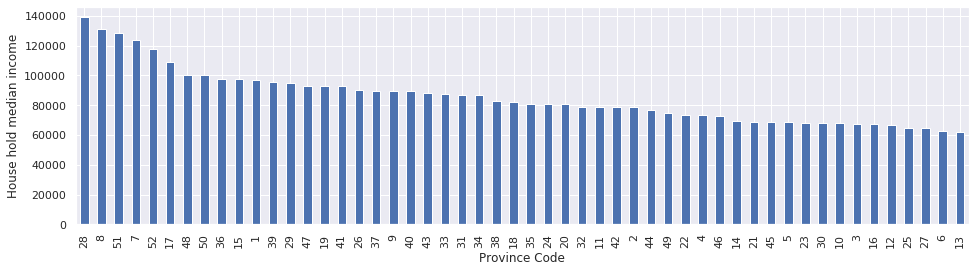

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
income_by_province["renta"].sort_values(ascending=False).plot(kind="bar", ax=ax)
ax.set_xlabel("Province Code")
ax.set_ylabel("House hold median income")

In [32]:
income_by_province = df_train.groupby("cod_prov")[["renta"]].median()
income_by_province = income_by_province.reset_index()
income_by_province.head()

,cod_prov,renta
0,1,96967.65
1,10,67799.49
2,11,79016.37
3,12,66630.30
4,13,62193.45


In [33]:
renta_impute_vals = df_train[["cod_prov"]].merge(income_by_province, how="left", on="cod_prov")
renta_impute_vals.head()

,cod_prov,renta
0,29,95102.61
1,13,62193.45
2,13,62193.45
3,50,99950.28
4,50,99950.28


In [34]:
renta_imputed = np.where(df_train["renta"].isnull(), renta_impute_vals["renta"], df_train["renta"])

## Imputer

In [35]:
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._use_mode = ["ind_empleado", "pais_residencia", "sexo", "indrel", 
                         "indresi", "indext", "indfall", "ind_actividad_cliente", 
                         "indrel_1mes", "tiprel_1mes", "canal_entrada", "cod_prov", 
                         "segmento", "ind_nomina_ult1", "ind_nom_pens_ult1"]
        
        self._use_median = ["age"]
        
        self._use_min = ["antiguedad"]
        
        self._use_true = ["ind_nuevo"]
        
        self._use_another_col = {"fecha_alta": ("fecha_dato", "min")}
        
        self._as_int = ["ind_nomina_ult1", "ind_nom_pens_ult1"]
    
    def fit(self, df):
        self._impute_values = {}
        for col in self._use_mode:
            self._impute_values[col] = df[col].mode()[0]
        
        for col in self._use_median:
            self._impute_values[col] = df[col].median()
            
        for col in self._use_min:
            self._impute_values[col] = df[col].min()
            
        for col in self._use_true:
            self._impute_values[col] = True
        
        for col in self._use_another_col:
            another_col = self._use_another_col[col][0]
            stat_func = self._use_another_col[col][1]
            self._impute_values[col] = df[another_col].apply(stat_func)
        
        self._renta_by_province = df.groupby("cod_prov")[["renta"]].median().reset_index()
        
        return self
    
    def transform(self, df):
        df = df.copy()
        all_cols = df.columns.to_list()
        for col, val in self._impute_values.items():
            if col in all_cols: 
                df[col] = df[col].fillna(val)
        
        renta_impute_vals = df[["cod_prov"]].merge(self._renta_by_province, how="left", on="cod_prov")
        df["renta"] = np.where(df["renta"].isnull(), renta_impute_vals["renta"], df["renta"])
        
        for col in self._as_int:
            if col in all_cols:
                df[col] = df[col].astype("int")
        
        return df
    

In [36]:
imputer = Imputer()
imputer.fit(df_train)
df_train = imputer.transform(df_train)
df_test = imputer.transform(df_test)

In [37]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [38]:
print_col_desc(df_train)

Name: fecha_dato
Type: datetime64[ns]
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 17
                             2015-01-28T00:00:00.000000000, 2015-02-28T00:00:00.000000000, 2015-03-28T00:00:00.000000000, 2015-04-28T00:00:00.000000000, 2015-05-28T00:00:00.000000000, 
                             2015-06-28T00:00:00.000000000, 2015-07-28T00:00:00.000000000, 2015-08-28T00:00:00.000000000, 2015-09-28T00:00:00.000000000, 2015-10-28T00:00:00.000000000, 
                             2015-11-28T00:00:00.000000000, 2015-12-28T00:00:00.000000000, 2016-01-28T00:00:00.000000000, 2016-02-28T00:00:00.000000000, 2016-03-28T00:00:00.000000000, 
                             2016-04-28T00:00:00.000000000, 2016-05-28T00:00:00.000000000
Min: 2015-01-28 00:00:00
Max: 2016-05-28 00:00:00
--------------------------------------------------

Name: ncodpers
Type: int32
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique

Max: 28894396.0
--------------------------------------------------

Name: segmento
Type: category
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 3
                             02 - PARTICULARES, 03 - 
                             UNIVERSITARIO, 01 - TOP
Mode:  [02 - PARTICULARES]
Categories (3, object): [01 - TOP, 02 - PARTICULARES, 03 - UNIVERSITARIO]
--------------------------------------------------

Name: ind_ahor_fin_ult1
Type: int32
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             0, 1
Min: 0
Max: 1
--------------------------------------------------

Name: ind_aval_fin_ult1
Type: int32
Number of rows: 13647309
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             0, 1
Min: 0
Max: 1
--------------------------------------------------

Name: ind_cco_fin_ult1
Type: int32
Number of rows: 13647309
Number of NUL

# Create new purchase indicator columns

In [39]:
def is_prod_purchased(ser):
    new_ser = (ser - ser.shift(1)).fillna(0).astype("int")
    return new_ser
    

def new_prod_purchase(df):
    df = df.copy()
    df = df.sort_values(by=["ncodpers", "fecha_dato"])
    
    regex = re.compile(r"^ind_.*_ult1$")
    prod_cols = [col for col in df.columns.to_list() if regex.match(col)]
    
    df_new = df[prod_cols].groupby(df["ncodpers"]).transform(is_prod_purchased)
    df_new = df_new.replace(-1, 0)
    df_new.columns = [col + "_NEW_PUR" for col in df_new.columns]
    
    return pd.concat([df, df_new], axis=1)

In [40]:
df_train = new_prod_purchase(df_train)

In [41]:
df_train.to_csv(os.path.join(OUT_DIR, "train_cleaned.csv"), index=False)
df_test.to_csv(os.path.join(OUT_DIR, "test_cleaned.csv"), index=False)